In [22]:
!ls

FAOSTAT_data_en_7-16-2023.csv  sample_data


# Import Library

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# Create a timeseries data

In [24]:
data = pd.read_csv("FAOSTAT_data_en_7-16-2023.csv")
data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371.0,"Almonds, in shell",1975,1975,ha,0.0,E,Estimated value
1,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371.0,"Almonds, in shell",1976,1976,ha,5900.0,E,Estimated value
2,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371.0,"Almonds, in shell",1977,1977,ha,6000.0,E,Estimated value
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371.0,"Almonds, in shell",1978,1978,ha,6000.0,E,Estimated value
4,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371.0,"Almonds, in shell",1979,1979,ha,6000.0,E,Estimated value


In [25]:
data.Item.value_counts()

Other vegetables, fresh n.e.c.                                                                                   2620
Maize (corn)                                                                                                     2244
Tomatoes                                                                                                         2139
Onions and shallots, dry (excluding dehydrated)                                                                  2024
Wheat                                                                                                            1884
                                                                                                                 ... 
Vanilla, raw                                                                                                       36
Balata, gutta-percha, guayule, chicle and similar natural gums in primary forms or in plates, sheets or strip      30
Kiwi fruit                                              

In [26]:
len(data.Item.unique())

144

In [27]:
data1 = data[data['Item']== 'Wheat']

In [28]:
df = data1[['Year','Value']]
df.head()

,Year,Value
5951,1961,2230000.0
5952,1962,2341000.0
5953,1963,2341000.0
5954,1964,2345000.0
5955,1965,2347000.0


In [29]:
df['Year'] = pd.to_datetime(df['Year'],format='%Y')
df.head()

<ipython-input-29-17e1e5ef1927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = pd.to_datetime(df['Year'],format='%Y')


,Year,Value
5951,1961-01-01,2230000.0
5952,1962-01-01,2341000.0
5953,1963-01-01,2341000.0
5954,1964-01-01,2345000.0
5955,1965-01-01,2347000.0


In [30]:
df.set_index('Year',inplace=True)

In [31]:
pd.isna(df).sum()

Value    0
dtype: int64

# Time series analysis

In [32]:
df.head()

,Value
Year,
1961-01-01,2230000.0
1962-01-01,2341000.0
1963-01-01,2341000.0
1964-01-01,2345000.0
1965-01-01,2347000.0


In [33]:
df.shape

(1884, 1)

In [34]:
df.describe()

,Value
count,1.884000e+03
mean,1.071813e+06
std,2.388308e+06
min,0.000000e+00
25%,1.000000e+04
50%,3.755250e+04
75%,1.353813e+06
max,1.977694e+07


<Axes: xlabel='Year'>

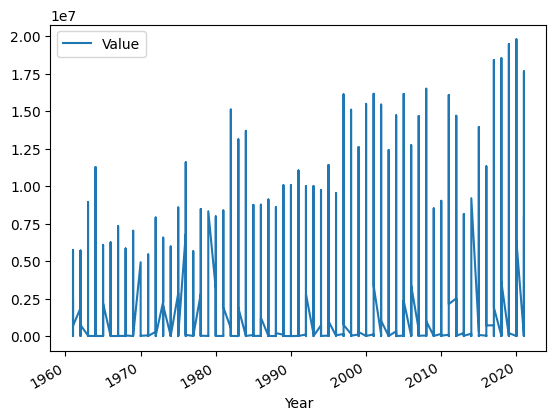

In [35]:
df.plot()

In [36]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [37]:
test_result=adfuller(df['Value'])

In [38]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [39]:
adfuller_test(df['Value'])

ADF Test Statistic : -4.845145462803335
p-value : 4.454306033610042e-05
#Lags Used : 20
Number of Observations Used : 1863
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Time Series Model



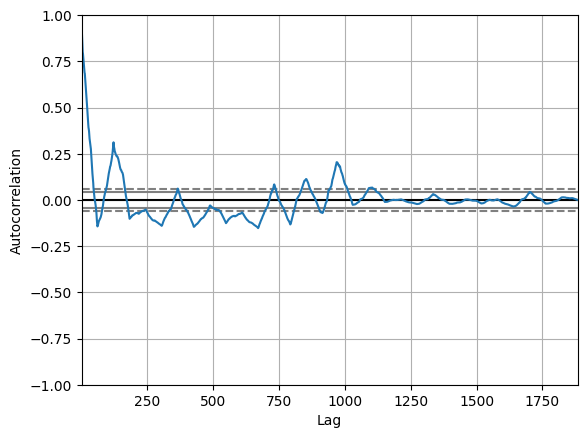

In [42]:

autocorrelation_plot(df['Value'])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


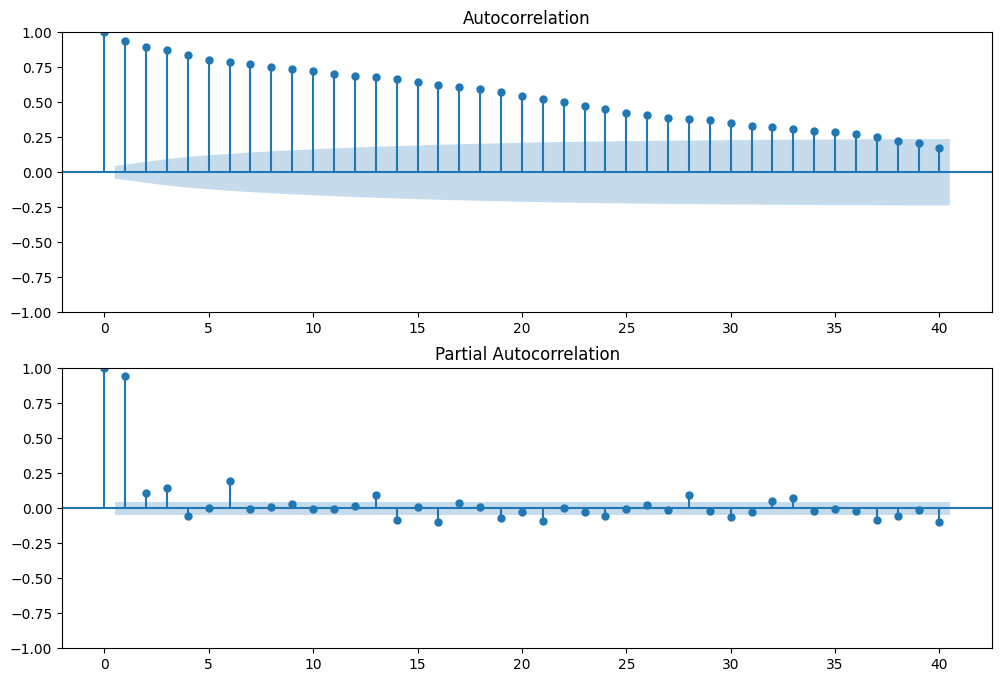

In [47]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Value'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Value'],lags=40,ax=ax2)

Since, ACF is declining gradually and PACF is declining instantly the best ML Model preffered here is Auto - Regressive Model.

### Implementation of Auto-Regressive Model

In [51]:
# split dataset for test and training
X = df.Value
train, test = X[1:len(X)-350], X[len(X)-350:]

In [108]:
# train autoregression
model = AutoReg(train, lags=20)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: const        40069.830122
Value.L1         0.856377
Value.L2        -0.024174
Value.L3         0.178085
Value.L4        -0.058972
Value.L5        -0.231987
Value.L6         0.245012
Value.L7        -0.048622
Value.L8         0.070128
Value.L9         0.004880
Value.L10       -0.034470
Value.L11       -0.028128
Value.L12       -0.074903
Value.L13        0.237540
Value.L14       -0.091881
Value.L15        0.066358
Value.L16       -0.160074
Value.L17        0.024158
Value.L18        0.093261
Value.L19       -0.007450
Value.L20       -0.053726
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
test[0]

190.0

In [109]:
# Predictions
start=len(train)
end=len(train)+len(test)-1
predictions = model_fit.predict(start, end, dynamic=False)
pred = predictions.reset_index(drop='index')
for i in range(len(pred)):
  print('predicted=%f, expected=%f' % (pred[i], test[i]))
rmse = sqrt(mean_squared_error(test, pred))
print('Test RMSE: %.3f' % rmse)

predicted=56839.778364, expected=190.000000
predicted=95746.176646, expected=300.000000
predicted=126538.937237, expected=190.000000
predicted=136294.414106, expected=200.000000
predicted=180577.789292, expected=200.000000
predicted=235383.600626, expected=250.000000
predicted=216597.035961, expected=270.000000
predicted=220027.264453, expected=270.000000
predicted=217488.073716, expected=270.000000
predicted=257761.777092, expected=300.000000
predicted=285046.802964, expected=300.000000
predicted=288011.682652, expected=300.000000
predicted=288640.550569, expected=300.000000
predicted=324217.685331, expected=500.000000
predicted=342331.615847, expected=500.000000
predicted=364365.406299, expected=500.000000
predicted=381766.767984, expected=500.000000
predicted=402441.435024, expected=500.000000
predicted=428735.966476, expected=500.000000
predicted=451634.223358, expected=500.000000
predicted=467899.177077, expected=500.000000
predicted=472552.649142, expected=500.000000
predicted=49

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


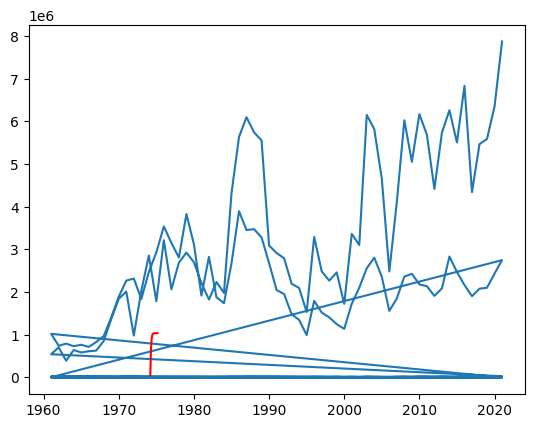

In [110]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()